In [61]:
import pandas as pd
import numpy as np
import datetime
import mysql.connector

First need to connect to the database and get the table

In [62]:
mydb = mysql.connector.connect(
  host="cinesave-2.chxybcbl9we4.us-east-1.rds.amazonaws.com",
  user="admin",
  password="Cinesave1",
  database = "sample"
)
print(mydb)
mycursor = mydb.cursor()

mycursor.execute("SELECT * FROM movie_revenue")

myresult = mycursor.fetchall()
df = pd.DataFrame(myresult, columns = mycursor.column_names)

Now just check that the data was loaded properly

In [63]:
print(df.iloc[:5,:]) #make sure the data has been properly loaded

                     name                  collection    budget      genre  \
0               Toy Story        Toy Story Collection  30000000  Animation   
1             Toy Story\n        Toy Story Collection  30000000  Animation   
2       American Psycho\n  American Psycho Collection   7000000   Thriller   
3                Psycho\n           Psycho Collection    806948     Horror   
4  Star Wars A new Hope\n        Star Wars Collection  11000000  Adventure   

   popularity release_date    revenue  runtime vote_average  vote_count  \
0          43   1995-10-30  373554033     81.0            8       12737   
1          43   1995-10-30  373554033     81.0            8       12737   
2          23   2000-01-21   34266564    102.0            7        5657   
3          26   1960-06-22   32000000    109.0            8        6480   
4          79   1977-05-25  775398007    121.0            8       14066   

    production_company   earnings  
0                Pixar  343554033  
1       

There appear to be '\n' characters in some of the names, so start by replacing those with blanks

In [64]:
df['name'] = df['name'].str.replace('\n', '')


We also see some duplicate names, such as with "Toy Story" athe very beginning, so we want to remove rows with repeat movies and check out the new dimensions

In [65]:
df = df.drop_duplicates(subset = "name")
print(df.iloc[:5,:])
df.size

                   name                     collection    budget      genre  \
0             Toy Story           Toy Story Collection  30000000  Animation   
2       American Psycho     American Psycho Collection   7000000   Thriller   
3                Psycho              Psycho Collection    806948     Horror   
4  Star Wars A new Hope           Star Wars Collection  11000000  Adventure   
5    Back to the Future  Back to the Future Collection  19000000  Adventure   

   popularity release_date    revenue  runtime vote_average  vote_count  \
0          43   1995-10-30  373554033     81.0            8       12737   
2          23   2000-01-21   34266564    102.0            7        5657   
3          26   1960-06-22   32000000    109.0            8        6480   
4          79   1977-05-25  775398007    121.0            8       14066   
5          51   1985-07-03  381109762    116.0            8       13592   

    production_company   earnings  
0                Pixar  343554033  
2 

776892

Succesfully dropped repeats and see that we are down to ~780000 movies

In order to not have to deal with issues of inflation, etc., we will want to limit our research to only movies released in 2000 or later. So we need to make a release year column and filter based on that

In [66]:
df.dtypes
df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['year'] = pd.DatetimeIndex(df['release_date']).year

Now that we have a year column we can get the rows with year greater than or equal to 2000

In [67]:
df = df.loc[df['year'] >= 2000]
print(df.iloc[:5,:])
df.size

                          name                  collection    budget  \
2              American Psycho  American Psycho Collection   7000000   
9   The Other Side of the Wind                              12000000   
11    The Wandering Soap Opera                                     0   
13                     Bigfoot                              30000000   
15               For the Cause                                     0   

              genre  popularity release_date   revenue  runtime vote_average  \
2          Thriller          23   2000-01-21  34266564    102.0            7   
9            Comedy          12   2018-11-02         0    122.0            7   
11          Fantasy           1   2017-08-10         0     80.0            7   
13        Animation          21   2017-07-26  46372519     92.0            6   
15  Science Fiction           3   2000-11-15         0    100.0            4   

    vote_count production_company  earnings    year  
2         5657   Muse Production

723593

This was successful and we are now down to ~55661 movies.

There is some strange behavior with movies that have 0 budget or 0 revenue, which are movies we are not considered with and need to remove from the dataset

In [68]:
df = df.loc[df['budget'] > 0]
df = df.loc[df['revenue'] > 0]
df.shape

(6386, 13)

This significantly cut down the number of movies in the dataset, we are now looking at 6386 movies.

Let's create a month column as well, as this may be linked to increased earnings around holidays, etc.

In [69]:
df['month'] = pd.DatetimeIndex(df['release_date']).month
print(df.iloc[:5,:])

                         name                  collection     budget  \
2             American Psycho  American Psycho Collection    7000000   
13                    Bigfoot                               30000000   
19                       Gang                               30000000   
24                    Glitter                               22000000   
34  The Sorcerer's Apprentice                              150000000   

        genre  popularity release_date    revenue  runtime vote_average  \
2    Thriller          23   2000-01-21   34266564    102.0            7   
13  Animation          21   2017-07-26   46372519     92.0            6   
19     Action          14   2006-09-15   41480851    125.0            7   
24      Drama           8   2001-09-21    5271666    104.0            4   
34    Fantasy          23   2010-07-13  215283742    109.0            6   

    vote_count    production_company  earnings    year  month  
2         5657      Muse Productions  27266564  2000

The categorical variables that we have are collection, genre, and production_company. Let's start with collection, where my intuition is what it's important is whether or not a movie is in a collection at all. 

In [70]:
df['in_collection'] = np.where(df['collection'] == '', 0, 1)

Let's check what percent of movies are in a collection

In [71]:
df['in_collection'].mean()

0.2209520826808644

Now let's see what the mean earnings are grouped by whether or not it is in a collection

In [72]:
df.groupby('in_collection')['revenue'].mean()

in_collection
0    7.501398e+07
1    2.876417e+08
Name: revenue, dtype: float64

Movies in collections make more money so good to keep this column as is. Next let's turn to genre. First, we need to see how many different genres there are. We can look at this and the earnings means at the same time

In [73]:
df.groupby('genre')['revenue'].mean()

genre
Action             1.998259e+08
Adventure          3.304610e+08
Animation          2.751604e+08
Comedy             6.985956e+07
Crime              6.918445e+07
Documentary        1.396956e+07
Drama              6.538012e+07
Family             2.074294e+08
Fantasy            1.854220e+08
History            1.081493e+08
Horror             6.582222e+07
Music              4.824655e+07
Mystery            8.492243e+07
Romance            5.201075e+07
Science Fiction    1.764738e+08
TV Movie           5.000000e+06
Thriller           6.967206e+07
War                1.399181e+08
Western            1.675938e+08
Name: revenue, dtype: float64

It's hard to see any clear trends here so we'll likely leave it as a factor later on. Finally let's look at the production company.

In [74]:
df['production_company'].nunique()

2080

There's too many production companies to sift through at once. We are most interested in how many movies a comapany has put out, so let's create a column in the dataframe that, for each movie, says how many movies the production company from that movie has put out.

In [75]:
grouped = df.groupby('production_company')['budget'].count().sort_values(ascending = False)
grouped = pd.DataFrame(grouped)
grouped['production_company'] = grouped.index
grouped = grouped.reset_index(drop = True)
prod_count_dict = grouped.set_index('production_company')['budget'].to_dict()
df['prod_company_popularity'] = df['production_company'].map(prod_count_dict)
print(df.iloc[:5,:])

                         name                  collection     budget  \
2             American Psycho  American Psycho Collection    7000000   
13                    Bigfoot                               30000000   
19                       Gang                               30000000   
24                    Glitter                               22000000   
34  The Sorcerer's Apprentice                              150000000   

        genre  popularity release_date    revenue  runtime vote_average  \
2    Thriller          23   2000-01-21   34266564    102.0            7   
13  Animation          21   2017-07-26   46372519     92.0            6   
19     Action          14   2006-09-15   41480851    125.0            7   
24      Drama           8   2001-09-21    5271666    104.0            4   
34    Fantasy          23   2010-07-13  215283742    109.0            6   

    vote_count    production_company  earnings    year  month  in_collection  \
2         5657      Muse Productions

Now, to see what effect this has, we can look at the correlation between the prod_company_popularity column and the earnings column.

In [76]:
df['revenue'].corr(df['prod_company_popularity'])

0.22476934460515405

It's not a huge correlation but definitely significant so we'll keep the column there. This means we can also now get rid of the original production_company column, as well as the original collection column

In [77]:
df = df.drop(columns=['production_company'])
df = df.drop(columns=['collection'])

Now we look at how movie earnings are related to the month of release.

In [78]:
df.groupby('month')['revenue'].mean()

month
1     6.504499e+07
2     1.145407e+08
3     9.626176e+07
4     1.478477e+08
5     1.658108e+08
6     2.006383e+08
7     1.634321e+08
8     7.507844e+07
9     5.759475e+07
10    9.270612e+07
11    1.740450e+08
12    1.588463e+08
Name: revenue, dtype: float64

There seem to be two pockets of increased sales: between april and june, and during decemeber and january.

In [79]:
month_list = [4, 5, 6, 7, 11, 12]
df['holiday_season'] = np.where(df['month'].isin(month_list), 1, 0)

We no longer need the release_date column now

In [80]:
df = df.drop(columns=['release_date'])

Due to the financial crisis, year is difficult to work with so we'll make it a category, as with genre

In [81]:
df['genre'] = df['genre'].astype('category')
df['year'] = df['year'].astype('category')

In [82]:
df['vote_average'] = df['vote_average'].astype('float64')
df_numeric = df.select_dtypes(include = ['int64', 'float64'])

In [83]:
df_numeric.corr()['revenue'][:].mean()

0.508823433203826

Important to note here that we now need to get rid of the revenue column, as this is information we assume to not know ahead of time

In [84]:
df = df.drop(columns = ['earnings'])

To start with, let's not use the name column, so we create a new dataframe without this value

In [85]:
df_noname = df.drop(columns = ['name'])

In [86]:
print(df_noname.iloc[:5,:])

       budget      genre  popularity    revenue  runtime  vote_average  \
2     7000000   Thriller          23   34266564    102.0           7.0   
13   30000000  Animation          21   46372519     92.0           6.0   
19   30000000     Action          14   41480851    125.0           7.0   
24   22000000      Drama           8    5271666    104.0           4.0   
34  150000000    Fantasy          23  215283742    109.0           6.0   

    vote_count    year  month  in_collection  prod_company_popularity  \
2         5657  2000.0      1              1                        1   
13         227  2017.0      7              0                       23   
19         503  2006.0      9              0                      152   
24          85  2001.0      9              0                        1   
34        3579  2010.0      7              0                      116   

    holiday_season  
2                0  
13               1  
19               0  
24               0  
34         

Before we do modeling we make assumptions about the distributions of the data. Thus we need to check the skewness of our numeric columns and, if they have an absolute value greater than 1, we need to take the log

In [87]:
df_numeric.skew(axis = 0) #check the skewness of each column

budget                     2.156048
popularity                 2.375609
revenue                    3.793163
runtime                    0.185696
vote_average              -1.825966
vote_count                 2.793779
earnings                   4.255491
month                     -0.159385
in_collection              1.345488
prod_company_popularity    2.217642
holiday_season             0.152055
dtype: float64

Using the above values, we now take log transformations of columns with a skew greater than 1, including the value we're predicting, which is revenue. Important to note that we don't take log transforms of binary variables, such as in_collection, even through its skewness value is greater than 1.

In [88]:
#df_noname['popularity'] = np.log(df_noname['popularity'] + .001)
#df_noname['revenue'] = np.log(df_noname['revenue'] + 1)
#df_noname['vote_count'] = np.log(df_noname['vote_count'] + 1)
#df_noname['prod_company_popularity'] = np.log(df_noname['prod_company_popularity'] + 1)

Let's now check the skewness values again

In [89]:
#df_numeric = df_noname.select_dtypes(include = ['int64', 'float64'])
#df_numeric.skew(axis = 0) #check the skewness of each column

Our final step is to scale the numerical variables between 0 and 1.

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_noname[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']])
df_noname[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']] = scaler.transform(df_noname[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']])


In [95]:
print(df_noname.iloc[:5,:])

      budget      genre  popularity    revenue   runtime  vote_average  \
2   0.018421   Thriller    0.148649   34266564  0.455357           0.7   
13  0.078947  Animation    0.135135   46372519  0.410714           0.6   
19  0.078947     Action    0.087838   41480851  0.558036           0.7   
24  0.057895      Drama    0.047297    5271666  0.464286           0.4   
34  0.394737    Fantasy    0.148649  215283742  0.486607           0.6   

    vote_count    year  month  in_collection  prod_company_popularity  \
2     0.212000  2000.0      1              1                        1   
13    0.008507  2017.0      7              0                       23   
19    0.018850  2006.0      9              0                      152   
24    0.003185  2001.0      9              0                        1   
34    0.134125  2010.0      7              0                      116   

    holiday_season  
2                0  
13               1  
19               0  
24               0  
34         

We are now ready to do the modeling. We are going to use a gradient boosting approach to perform the regression. Thus, we need to first load the necessary packages. Additionally, we need to do one hot encoding in order to be able to use the categorical data in our model.

In [96]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [97]:
df_noname = df_noname.reset_index()
labelencoder = LabelEncoder()
enc = OneHotEncoder()
df_noname['genre_cat'] = labelencoder.fit_transform(df_noname['genre'])
df_noname['year_cat'] = labelencoder.fit_transform(df_noname['year'])
enc_genre_df = pd.DataFrame(enc.fit_transform(df_noname[['genre_cat']]).toarray())
enc_genre_df.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9',
               'genre10', 'genre11', 'genre12', 'genre13', 'genre14', 'genre15', 'genre16', 'genre17', 'genre18', 'genre19']

enc_year_df = pd.DataFrame(enc.fit_transform(df_noname[['year_cat']]).toarray())
enc_year_df.columns = ['year1', 'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9', 'year10',
                      'year11', 'year12', 'year13', 'year14', 'year15', 'year16', 'year17', 'year18', 'year19', 'year20', 'year21']

df_noname = df_noname.join(enc_genre_df)
df_noname = df_noname.join(enc_year_df)
print(df_noname.iloc[:5,:])
print(df_noname.isna().sum())

   index    budget      genre  popularity    revenue   runtime  vote_average  \
0      2  0.018421   Thriller    0.148649   34266564  0.455357           0.7   
1     13  0.078947  Animation    0.135135   46372519  0.410714           0.6   
2     19  0.078947     Action    0.087838   41480851  0.558036           0.7   
3     24  0.057895      Drama    0.047297    5271666  0.464286           0.4   
4     34  0.394737    Fantasy    0.148649  215283742  0.486607           0.6   

   vote_count    year  month  ...  year12  year13  year14  year15  year16  \
0    0.212000  2000.0      1  ...     0.0     0.0     0.0     0.0     0.0   
1    0.008507  2017.0      7  ...     0.0     0.0     0.0     0.0     0.0   
2    0.018850  2006.0      9  ...     0.0     0.0     0.0     0.0     0.0   
3    0.003185  2001.0      9  ...     0.0     0.0     0.0     0.0     0.0   
4    0.134125  2010.0      7  ...     0.0     0.0     0.0     0.0     0.0   

   year17  year18  year19  year20  year21  
0     0.0   

/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "cate

Our last remaining issue is that the runtime column has some NaN values in it. We'll replace these with the mean runtime

In [98]:
df_noname['runtime'] = df_noname['runtime'].fillna(df_noname['runtime'].mean())
print(df_noname.isna().sum())

index                      0
budget                     0
genre                      0
popularity                 0
revenue                    0
runtime                    0
vote_average               0
vote_count                 0
year                       0
month                      0
in_collection              0
prod_company_popularity    0
holiday_season             0
genre_cat                  0
year_cat                   0
genre1                     0
genre2                     0
genre3                     0
genre4                     0
genre5                     0
genre6                     0
genre7                     0
genre8                     0
genre9                     0
genre10                    0
genre11                    0
genre12                    0
genre13                    0
genre14                    0
genre15                    0
genre16                    0
genre17                    0
genre18                    0
genre19                    0
year1         

Our columns are now properly encoded, meaning we can move to applying the gradient boosting algorithm. First, we need to split our data into a train and test set. We'll use 70% for train and 30% for test. Additionally, we split our data into X (features) and y (output) sets as well

In [99]:
import sklearn.model_selection as model_selection
X = df_noname.drop(['index', 'genre', 'revenue', 'year', 'month'], axis = 1)
y = df_noname['revenue']
[X_train, X_test, y_train, y_test] = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)

In [100]:
gradient_boosting_regressor = ensemble.GradientBoostingRegressor()

In [101]:
gradient_boosting_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [102]:
print(gradient_boosting_regressor.score(X_train, y_train))

0.922624584944219


In [103]:
y_test_predictions = gradient_boosting_regressor.predict(X_test)

In [104]:
print(gradient_boosting_regressor.score(X_test, y_test))

0.8760745545300285


In [105]:
feature_importance = gradient_boosting_regressor.feature_importances_

In [106]:
feature_importance

array([3.27709721e-01, 6.76504758e-02, 8.10544480e-03, 2.40004784e-03,
       5.29785234e-01, 2.68795627e-02, 5.02944099e-03, 1.31119268e-03,
       1.64011690e-03, 1.37611028e-02, 1.01038620e-04, 5.86247157e-04,
       2.11473437e-03, 3.17212546e-04, 0.00000000e+00, 0.00000000e+00,
       2.30038202e-04, 2.57573368e-04, 7.08110292e-05, 5.05452152e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.67020699e-04, 0.00000000e+00, 0.00000000e+00, 2.43505750e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.73048998e-04,
       0.00000000e+00, 2.80644118e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.76446769e-05, 3.94916694e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.00841852e-04, 5.76227182e-04,
       4.19207012e-03, 1.65105025e-04, 5.40767342e-04, 1.51875707e-03,
       1.21218968e-03, 5.93707119e-07])

Text(0.5, 1.0, 'Feature Importance (MDI)')

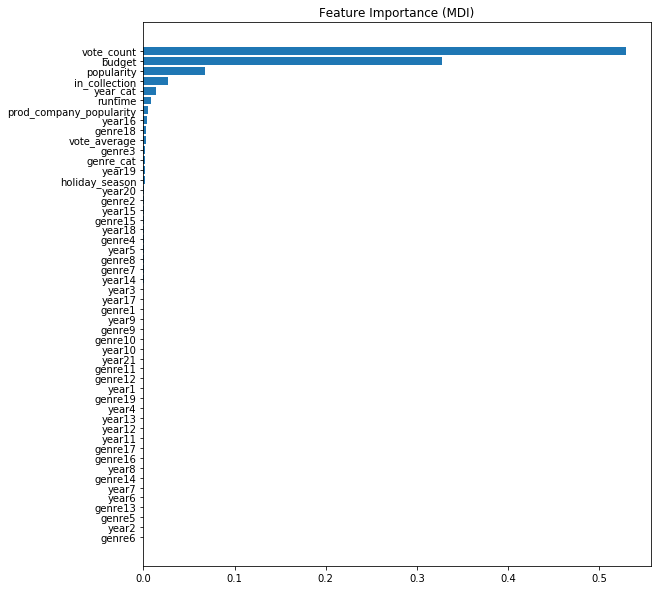

In [107]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

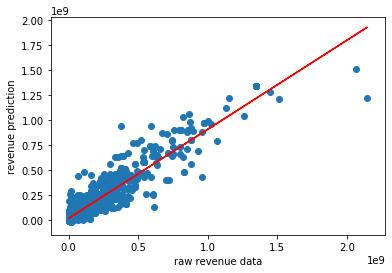

0.8918413684226112


In [108]:
[m,b] = np.polyfit(y_test, y_test_predictions, 1)
plt.plot(y_test, m*y_test + b, 'r')
plt.scatter(y_test, y_test_predictions)
plt.xlabel("raw revenue data")
plt.ylabel("revenue prediction")
plt.show()
print(m)

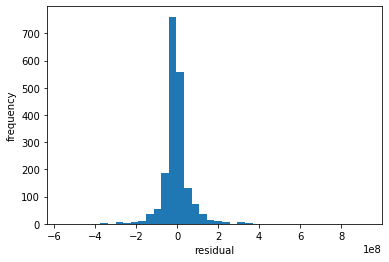

In [109]:
plt.hist(y_test - y_test_predictions, bins = 40)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

In [110]:
feature_importance[sorted_idx]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.93707119e-07, 3.94916694e-05,
       5.05452152e-05, 7.08110292e-05, 9.76446769e-05, 1.01038620e-04,
       1.65105025e-04, 1.73048998e-04, 2.00841852e-04, 2.30038202e-04,
       2.57573368e-04, 2.80644118e-04, 3.17212546e-04, 5.40767342e-04,
       5.67020699e-04, 5.76227182e-04, 5.86247157e-04, 1.21218968e-03,
       1.31119268e-03, 1.51875707e-03, 1.64011690e-03, 2.11473437e-03,
       2.40004784e-03, 2.43505750e-03, 4.19207012e-03, 5.02944099e-03,
       8.10544480e-03, 1.37611028e-02, 2.68795627e-02, 6.76504758e-02,
       3.27709721e-01, 5.29785234e-01])